In [9]:
import datasets as ds
import utils as ut
import models as md

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz


# fairlearn
import fasttext

# libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_theme()

from sklearn.model_selection import ShuffleSplit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1: Auditing with repsect to stereotypes 

In [3]:
rep = "WE"
ft = fasttext.load_model("cc.en.300.bin")
occupation = "attorney"
all_dataset = ds.Dataset("biasbios", target_occ=occupation, rep=rep)
all_dataset.split_train_test()
print(len(all_dataset.y_train))
occ_dataset = ds.Dataset("biasbios", target_occ=occupation, rep=rep, balanced=True)
occ_dataset.split_train_test()
print(len(occ_dataset.y_train))

generating fast text vectors


46878it [00:30, 1545.61it/s]


32814
generating fast text vectors


8860it [00:05, 1610.33it/s]


6202


In [7]:
# base predictor
clf = LogisticRegression(max_iter=500)
clf.fit(occ_dataset.x_train, occ_dataset.y_train)

p = clf.predict_proba(occ_dataset.x_test)[:, 1]
p_acc = accuracy_score(occ_dataset.y_test, p > 0.5)

mask = occ_dataset.g_test == 0
male_acc = accuracy_score(occ_dataset.y_test[mask], p[mask] > 0.5)
female_acc = accuracy_score(occ_dataset.y_test[~mask], p[~mask] > 0.5)

print(
    f"base clf acc: {p_acc:.3f} male acc: {male_acc:.3f} female acc: {female_acc:.3f}"
)

base clf acc: 0.887 male acc: 0.893 female acc: 0.884


In [8]:
g_clf = LogisticRegression(max_iter=500)
g_clf.fit(occ_dataset.x_train, occ_dataset.g_train)
g_occ_pred = g_clf.predict_proba(occ_dataset.x_test)[:, 1]
print(
    f"clf g_occ acc: {accuracy_score(occ_dataset.g_test, 
                                       g_clf.predict(occ_dataset.x_test)):.3f}"
)

occ_clf = LogisticRegression(max_iter=500)
occ_clf.fit(all_dataset.x_train, all_dataset.g_train)
g_all_pred = occ_clf.predict_proba(all_dataset.x_test)[:, 1]
print(
    f"clf g acc: {accuracy_score(all_dataset.g_test, 
                                  occ_clf.predict(all_dataset.x_test)):.3f}"
)

clf g_occ acc: 0.666
clf g acc: 0.661


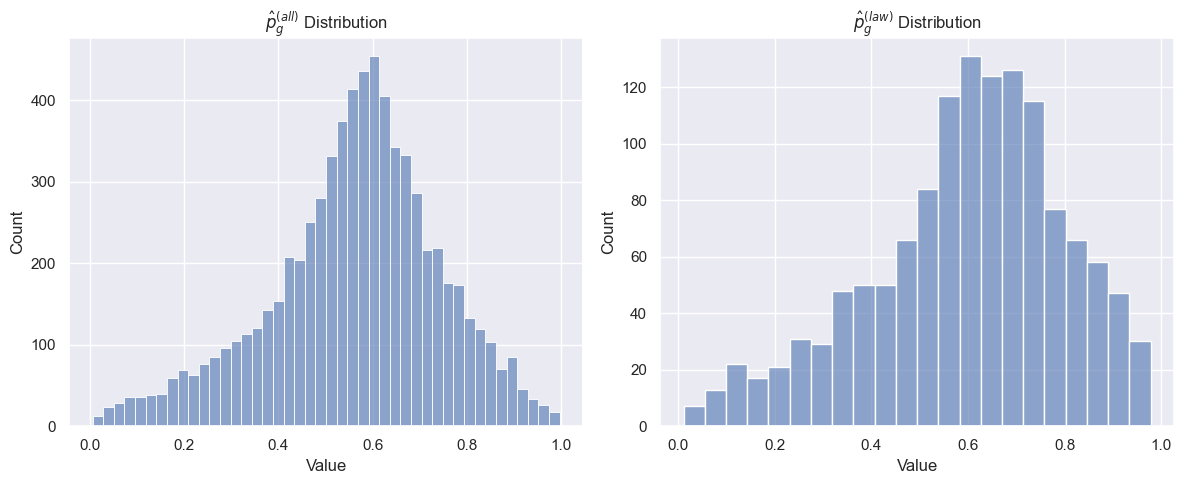

In [11]:
plt.figure(figsize=(12, 5))

# First histogram
plt.subplot(1, 2, 1)
sns.histplot(data=g_all_pred, alpha=0.6)
plt.title(r"$\hat{p}_g^{(all)}$ Distribution")
plt.xlabel("Value")
plt.ylabel("Count")

# Second histogram
plt.subplot(1, 2, 2)
sns.histplot(data=g_occ_pred, alpha=0.6)
plt.title(r"$\hat{p}_g^{(law)}$ Distribution")
plt.xlabel("Value")
plt.ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
def find_means(input_x, input_g, n_dim=2):
    # hard coded gender dimensions
    gendered_word_list = [
        ("man", "woman"),
        ("men", "women"),
        ("he", "she"),
        ("boy", "girl"),
        ("king", "queen"),
        ("male", "female"),
        ("son", "daughter"),
        ("himself", "herself"),
        ("his", "hers"),
        ("guy", "gal"),
        ("father", "mother"),
    ]

    top_diff_dim = []
    for word1, word2 in gendered_word_list:
        m = ft.get_word_vector(word1)
        f = ft.get_word_vector(word2)
        diff_vec = f - m
        top_diff_dim.append(np.argsort(diff_vec)[:5])  # [::-1][:10])

    vals, cnts = np.unique(np.concatenate(top_diff_dim), return_counts=True)
    ind = vals[np.argsort(cnts)[::-1]][:n_dim]
    x = input_x[:, ind]

    mask = input_g == 0
    group1_mean = np.mean(x[mask], axis=0)
    mask = input_g == 1
    group2_mean = np.mean(x[mask], axis=0)

    empirical_means = np.vstack([group1_mean, group2_mean]).T
    return empirical_means, ind


def infer_fuzzy(input_data, ind, cntr, n_dim=2):
    print(input_data[:, ind].T.shape, cntr.shape)
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
        test_data=input_data[:, ind].T,  # S x c
        cntr_trained=cntr,  # S x c
        m=2,
        error=0.005,
        maxiter=1000,
    )
    return u

In [13]:
# stereotype predictors:
# 1) overall pg
all_pg_clf = LogisticRegression(max_iter=500)
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)
all_pg = all_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

# 2) professor pg
occ_pg_clf = LogisticRegression(max_iter=500)
occ_pg_clf.fit(occ_dataset.x_train, occ_dataset.g_train)
occ_pg = occ_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

# 4) clustering
cntr, ind = find_means(
    input_x=occ_dataset.x_train, input_g=occ_dataset.g_train, n_dim=4
)

cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

In [14]:
# evaluate stereotype predictors

results = {}
p = clf.predict_proba(occ_dataset.x_test)[:, 1]
for pg, name in zip([all_pg, occ_pg, cluster_pg], ["all_pg", "occ_pg", "cluster_pg"]):
    print(name)
    # group prediction accuracy
    print(f"acc {accuracy_score(occ_dataset.g_test, pg>0.5):.3f}")
    print("cov(y, pg)", ut.emp_cov(occ_dataset.y_test, pg))
    print("corr(y, pg)", stats.pearsonr(occ_dataset.y_test, pg))
    print("cov(p, pg)", ut.emp_cov(p, pg))
    print("corr(p, pg)", stats.pearsonr(p, pg))
    results[name] = {}
    results[name]["DP"] = ut.emp_cov(p, pg)
    results[name]["DP_corr"] = stats.pearsonr(p, pg)

    mask = occ_dataset.y_test == 1
    print("cov(p, pg | y=1)", ut.emp_cov(p[mask], pg[mask]))
    print("corr(p, pg | y=1)", stats.pearsonr(p[mask], pg[mask]))
    results[name]["EO"] = ut.emp_cov(p[mask], pg[mask])
    results[name]["EO_corr"] = stats.pearsonr(p[mask], pg[mask])

    results[name]["MA"] = np.abs(ut.emp_cov(p, pg) - ut.emp_cov(occ_dataset.y_test, pg))

all_pg
acc 0.661
cov(y, pg) 0.010362296033623793
corr(y, pg) PearsonRResult(statistic=np.float64(0.11739278274225597), pvalue=np.float64(1.7833353879792278e-05))
cov(p, pg) 0.010654948226761529
corr(p, pg) PearsonRResult(statistic=np.float64(0.1437125667779784), pvalue=np.float64(1.4287641596810523e-07))
cov(p, pg | y=1) 0.0023854419540291255
corr(p, pg | y=1) PearsonRResult(statistic=np.float64(0.06006406633665495), pvalue=np.float64(0.12205078296312463))
occ_pg
acc 0.666
cov(y, pg) 0.016128209770784527
corr(y, pg) PearsonRResult(statistic=np.float64(0.15924214191394503), pvalue=np.float64(5.312813448067718e-09))
cov(p, pg) 0.017017608212855875
corr(p, pg) PearsonRResult(statistic=np.float64(0.2000453073005431), pvalue=np.float64(1.8335941821652137e-13))
cov(p, pg | y=1) 0.003928531480889716
corr(p, pg | y=1) PearsonRResult(statistic=np.float64(0.0820433719570081), pvalue=np.float64(0.03454168375346984))
cluster_pg
acc 0.547
cov(y, pg) 0.0020187175987785655
corr(y, pg) PearsonRResult(

## Demographic Parity

In [ ]:
# DP Post Processing
DP_plot = []
dataset = occ_dataset

all_pg_clf = LogisticRegression(max_iter=500)
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

i = 0
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = occ_dataset.x_train[train_idx]
    y_train_sub = occ_dataset.y_train[train_idx]
    g_train_sub = occ_dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)

    # 2b) professor pg
    occ_pg_clf = LogisticRegression()
    occ_pg_clf.fit(x_train_sub, g_train_sub)
    occ_pg = occ_pg_clf.predict_proba(x_train_sub)[:, 1]

    # 2c) clustering
    cntr, ind = find_means(input_x=x_train_sub, input_g=g_train_sub, n_dim=4)

    cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
    cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

    pg_dict = {"all_pg": all_pg_clf, "occ_pg": occ_pg_clf, "cluster_pg": cluster_pg_clf}

    prev_results = ut.results_summary(
        p=clf.predict_proba(dataset.x_test)[:, 1],
        pg_dict=pg_dict,
        x=occ_dataset.x_test,
        y=occ_dataset.y_test,
        g=occ_dataset.g_test,
    )

    clfs = [
        ([all_pg_clf], r"$\hat{p}_g^{(all)}$"),
        ([occ_pg_clf], r"$\hat{p}_g^{(law)}$"),
        ([cluster_pg_clf], r"$\hat{p}_g^{(FCM)}$"),
        (
            [all_pg_clf, occ_pg_clf, cluster_pg_clf],
            r"$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$",
        ),
    ]

    for clf_list, clf_list_name in clfs:
        clf = LogisticRegression()
        clf.fit(x_train_sub, y_train_sub)

        if clf_list_name == r"$\hat{p}_g^{(FCM)}$":
            for key in pg_dict.keys():
                DP_plot.append(
                    {
                        "eval_pg": key,
                        "intervention_pg": "None",
                        "value": prev_results[f"cov(p, {key})"],
                        "run": i,
                        "acc": prev_results["accuracy"],
                    }
                )

        c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
        md.fit_dp_pg_multi(
            x=x_train_sub, multi_clf=c_post_processed, alpha=1e-4, max_iter=50
        )

        results = ut.results_summary(
            p=c_post_processed.predict_proba_1d(dataset.x_test),
            pg_dict=pg_dict,
            x=occ_dataset.x_test,
            y=occ_dataset.y_test,
            g=occ_dataset.g_test,
        )
        for key in pg_dict.keys():
            DP_plot.append(
                {
                    "eval_pg": key,
                    "intervention_pg": f"DP wrt. {clf_list_name}",
                    "value": results[f"cov(p, {key})"],
                    "acc": results["accuracy"],
                    "run": i,
                }
            )

In [18]:
plot_df = pd.DataFrame(DP_plot)
plot_map = {
    "all_pg": r"$\hat{p}_g^{(all)}$",
    "occ_pg": r"$\hat{p}_g^{(law)}$",
    "cluster_pg": r"$\hat{p}_g^{(FCM)}$",
}
plot_df["eval_pg"] = plot_df["eval_pg"].map(plot_map)
acc_dict = plot_df.groupby("intervention_pg")["acc"].mean().to_dict()

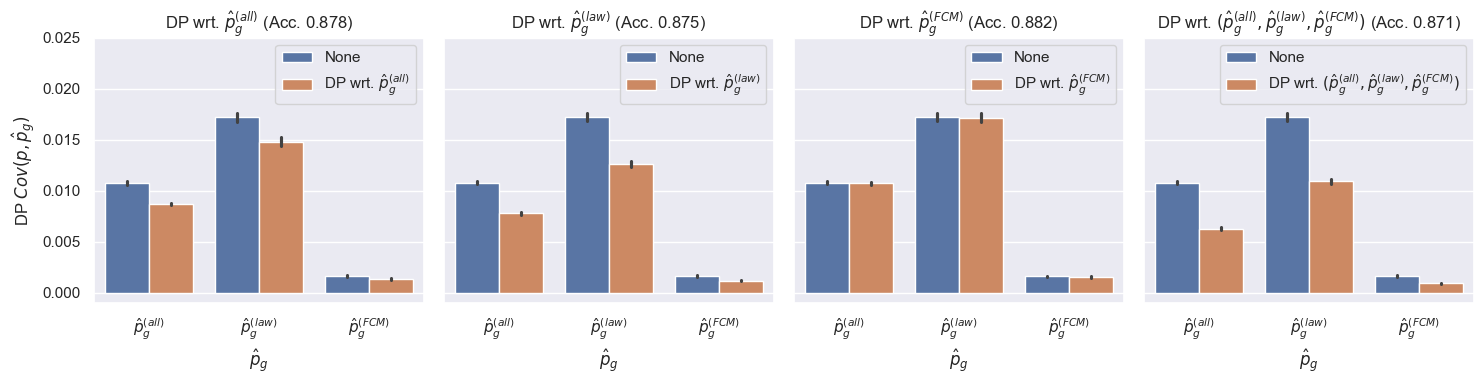

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

intervention_list = [
    key for key in plot_df["intervention_pg"].value_counts().index if key != "None"
]

for i, key in enumerate(intervention_list):
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df["intervention_pg"].isin([key, "None"])]
    sns.barplot(
        data=subplot_df,
        x="eval_pg",
        hue_order=["None", key],
        y="value",
        hue="intervention_pg",
        ax=ax,
    )
    ax.legend(title=None, loc="upper right")
    ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r"$\hat{p}_g$")
    ax.set_ylabel(r"DP $Cov(p, \hat{p}_g)$")
    ax.set_title(f"{key} (Acc. {acc_dict[key]:.3f})")

plt.tight_layout()
# plt.savefig('img/bios/dp_all_bios.pdf') uncomment to save the plot

## Equal Opportunity

In [ ]:
# EO Post Processing
EO_plot = []

dataset = occ_dataset

clf_list_name = r"$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$"
# all pg one time:
# 2a) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(all_dataset.x_train, all_dataset.g_train)

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
acc_list = []

i = 0
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = occ_dataset.x_train[train_idx]
    y_train_sub = occ_dataset.y_train[train_idx]
    g_train_sub = occ_dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)

    # 2b) professor pg
    occ_pg_clf = LogisticRegression()
    occ_pg_clf.fit(x_train_sub, g_train_sub)
    occ_pg = occ_pg_clf.predict_proba(x_train_sub)[:, 1]

    # 2c) clustering
    cntr, ind = find_means(input_x=x_train_sub, input_g=g_train_sub, n_dim=4)

    cluster_pg_clf = md.FuzzyClusterPredictor(cntr.T, ind)
    cluster_pg = cluster_pg_clf.predict_proba(occ_dataset.x_test)[:, 1]

    pg_dict = {"all_pg": all_pg_clf, "occ_pg": occ_pg_clf, "cluster_pg": cluster_pg_clf}

    prev_results = ut.results_summary(
        p=clf.predict_proba(dataset.x_test)[:, 1],
        pg_dict=pg_dict,
        x=occ_dataset.x_test,
        y=occ_dataset.y_test,
        g=occ_dataset.g_test,
    )

    clfs = [
        ([all_pg_clf], r"$\hat{p}_g^{(all)}$"),
        ([occ_pg_clf], r"$\hat{p}_g^{(harm)}$"),
        ([cluster_pg_clf], r"$\hat{p}_g^{(FCM)}$"),
        (
            [all_pg_clf, occ_pg_clf, cluster_pg_clf],
            r"$(\hat{p}_g^{(all)}, \hat{p}_g^{(harm)}, \hat{p}_g^{(FCM)})$",
        ),
    ]

    for clf_list, clf_list_name in clfs:
        if clf_list_name == r"$\hat{p}_g^{(FCM)}$":
            for key in pg_dict.keys():
                EO_plot.append(
                    {
                        "eval_pg": key,
                        "intervention_pg": "None",
                        "value": np.abs(prev_results[f"cov(p, {key} |y=1)"]),
                        "run": i,
                        "acc": prev_results["accuracy"],
                    }
                )

        eo_clf = md.EOClf(base_clf=clf, pg_clf_list=clf_list)
        eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)

        results = ut.results_summary(
            p=eo_clf.predict_proba(dataset.x_test)[:, 1],
            pg_dict=pg_dict,
            x=occ_dataset.x_test,
            y=occ_dataset.y_test,
            g=occ_dataset.g_test,
        )
        for key in pg_dict.keys():
            EO_plot.append(
                {
                    "eval_pg": key,
                    "intervention_pg": f"EO wrt. {clf_list_name}",
                    "value": np.abs(results[f"cov(p, {key} |y=1)"]),
                    "acc": results["accuracy"],
                    "run": i,
                }
            )

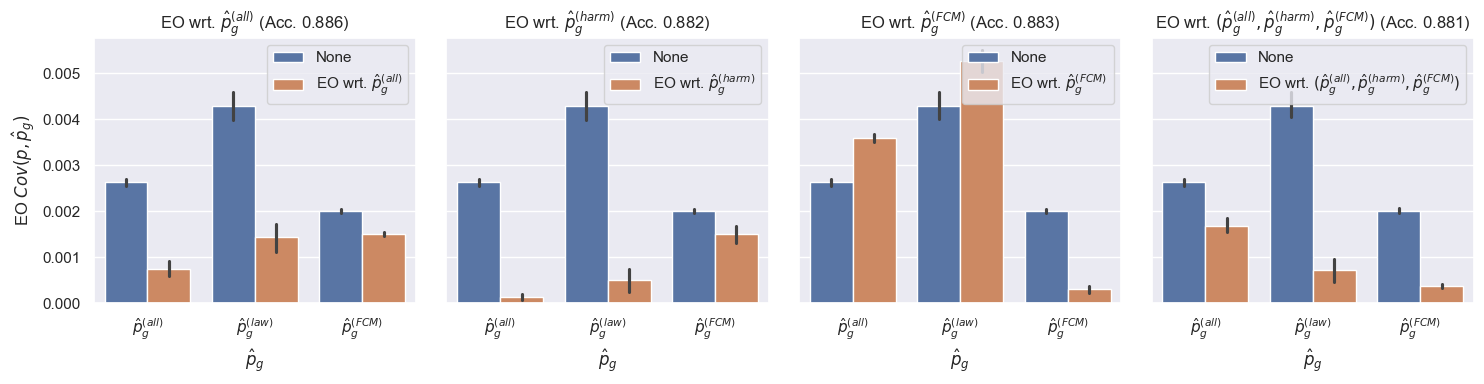

In [29]:
plot_df = pd.DataFrame(EO_plot)
plot_map = {
    "all_pg": r"$\hat{p}_g^{(all)}$",
    "occ_pg": r"$\hat{p}_g^{(law)}$",
    "cluster_pg": r"$\hat{p}_g^{(FCM)}$",
}
plot_df["eval_pg"] = plot_df["eval_pg"].map(plot_map)
acc_dict = plot_df.groupby("intervention_pg")["acc"].mean().to_dict()

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

intervention_list = [
    key for key in plot_df["intervention_pg"].value_counts().index if key != "None"
]


for i, key in enumerate(intervention_list):
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df["intervention_pg"].isin([key, "None"])]
    sns.barplot(
        data=subplot_df,
        x="eval_pg",
        y="value",
        hue_order=["None", key],
        hue="intervention_pg",
        ax=ax,
    )
    ax.legend(title=None, loc="upper right")
    ax.set_xlabel(r"$\hat{p}_g$")
    ax.set_ylabel(r"EO $Cov(p, \hat{p}_g)$")
    ax.set_title(f"{key} (Acc. {acc_dict[key]:.3f})")

plt.tight_layout()
plt.savefig("img/bios/eo_all_bios.pdf")